# Training an LSTM model on books dataset

First we import necessary packages for our project

In [1]:
import json
from matplotlib import pyplot as plt
import numpy as np
import os
from pathlib import Path
import pickle
import random
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tqdm import tqdm

Set `seaborn` for better data visualization

In [2]:
sns.set()

## Preparing Dataset

Initialize the project root, data, and model related directories. `processed_data` directory contains selected books from renowned authors only.

In [3]:
# get data and model directories
project_root = Path('__file__').resolve().parents[1]
data_dir = project_root / 'processed_data/'
model_home = project_root / 'models/bn_lstm'

plot_dir = model_home / 'plots'
history_and_tokenizer_dir = model_home / 'history_and_tokenizer'
model_saved_dir = model_home / 'model'

os.makedirs(model_home, exist_ok=True)
os.makedirs(plot_dir, exist_ok=True)
os.makedirs(history_and_tokenizer_dir, exist_ok=True)
os.makedirs(model_saved_dir, exist_ok=True)

Get list of files in the data directory

In [4]:
filenames = [str(file) for file in Path(data_dir).glob('**/*.txt')]

Then we randomly shuffle the filenames list and select 100 files.

In [5]:
random.shuffle(filenames)
filenames = filenames[:100]

Split the files for training and testing. We are keeping 20% for testing and 80% for training.

In [6]:
train_test_split = 0.2
train_size = int(len(filenames) * train_test_split)
training_filenames = filenames[:-train_size]
test_filenames = filenames[-train_size:]

Now we create a function that creates a tokenizer with `max_words`, fit it on training files and save to `model_dir`.

In [21]:
def create_tokenizer(files, max_words, model_dir):
    tokenizer = Tokenizer(num_words=max_words)
    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace new lines with space
            tokenizer.fit_on_texts([lines])
    save_path = history_and_tokenizer_dir / f'tokenizer_{max_words}_words.pickle'
    # save the tokenizer in model dir
    with open(save_path, 'wb') as handle:
        pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)
    
    # save word_index as json for use with android studio
    with open(str(history_and_tokenizer_dir / 'word_index.json'), 'w') as handle:
        json.dump(tokenizer.word_index, handle)
    return tokenizer

Define max words and max sequence length

In [22]:
MAX_WORDS = 10000
MAX_SEQUENCE_LENGTH = 200

Now create the tokenizer calling the function and passing the defined constants

In [23]:
tokenizer = create_tokenizer(training_filenames, MAX_WORDS, history_and_tokenizer_dir)

100%|███████████████████████████████████████████| 80/80 [00:11<00:00,  6.98it/s]


`create_dataset` creates a dataset from given `files` and returns two variables - `predictors` which is a sequence of previous words of length `max_sequence_length - 1` and `labels` which is an integer between 0 to `max_words + 1`.
Note that, converting to categorical variables leads to `MemoryError` since it tries to create a sequence of `number of elements in training or test set * (MAX_WORDS + 1)` shape. We are following [this blog](https://medium.com/deep-learning-with-keras/which-activation-loss-functions-in-multi-class-clasification-4cd599e4e61f) and keeping the label as an integer.

In [25]:
def create_dataset(tokenizer, files, max_sequence_length):
    input_sequences = []

    for file in tqdm(files):
        with open(file, 'r') as f:
            lines = f.read().replace('\n', ' ') # replace all new lines with spaces
            token_list = tokenizer.texts_to_sequences([lines])
            for tokens in token_list:
                for i in range(1, len(tokens)):
                    # keep only sequences of length <= max_sequence_length
                    n_gram_sequence = tokens[max(0, i+1-max_sequence_length):i+1]
                    input_sequences.append(n_gram_sequence)

    # pad sequences with 0s so that all sequences have same length
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(
        input_sequences, maxlen=max_sequence_length, padding='pre')

    predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
    del input_sequences
    return predictors, label

Now we create training dataset `X_train` and `y_train` from training files and test dataset `X_test` and `y_test` from test files.

In [26]:
X_train, y_train = create_dataset(tokenizer, training_filenames, MAX_SEQUENCE_LENGTH)
X_test, y_test = create_dataset(tokenizer, test_filenames, MAX_SEQUENCE_LENGTH)

100%|███████████████████████████████████████████| 20/20 [00:03<00:00,  5.67it/s]


## Creating and Training Model

We create three sequential LSTM models with different parameters and architectures, and compile the models with loss `sparse_categorical_crossentropy`, optimizer `adam` and metric `sparse_categorical_accuracy`. We are using sparse categorical crossentropy since the values are integers, not one-hot encoded, see this question on [stackexchange](https://stats.stackexchange.com/questions/326065/cross-entropy-vs-sparse-cross-entropy-when-to-use-one-over-the-other) for details.

### Model 1

Two LSTM layers each with 150 units and dropout of 20%

In [27]:
model1 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150, return_sequences=True, dropout=0.2),
    tf.keras.layers.LSTM(150, dropout=0.2),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model1.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

We set callback `EarlyStopping` that monitors `val_loss` for 10 epochs and stops training if it does not improve.

In [28]:
earlystop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss', min_delta=0, patience=10, mode='auto')

Train the model with 20% validation split and save history

In [29]:
history1 = model1.fit(X_train, y_train, batch_size=1024, epochs=50,
                      use_multiprocessing=True,
                      validation_split=0.2, callbacks=[earlystop])
with open(str(history_and_tokenizer_dir / 'model_1_history'), 'wb') as history_pkl:
    pickle.dump(history1, history_pkl)

Epoch 1/50


2022-04-08 21:04:44.136530: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1495330576 exceeds 10% of free system memory.


1835/1835 [==============================] - 526s 286ms/step - loss: 7.5550 - sparse_categorical_accuracy: 0.0247 - val_loss: 7.3781 - val_sparse_categorical_accuracy: 0.0365
Epoch 2/50
1835/1835 [==============================] - 529s 288ms/step - loss: 6.9436 - sparse_categorical_accuracy: 0.0488 - val_loss: 7.0815 - val_sparse_categorical_accuracy: 0.0529
Epoch 3/50
1835/1835 [==============================] - 528s 288ms/step - loss: 6.6268 - sparse_categorical_accuracy: 0.0625 - val_loss: 6.9346 - val_sparse_categorical_accuracy: 0.0609
Epoch 4/50
1835/1835 [==============================] - 534s 291ms/step - loss: 6.4180 - sparse_categorical_accuracy: 0.0708 - val_loss: 6.8669 - val_sparse_categorical_accuracy: 0.0652
Epoch 5/50
1835/1835 [==============================] - 523s 285ms/step - loss: 6.2710 - sparse_categorical_accuracy: 0.0771 - val_loss: 6.8101 - val_sparse_categorical_accuracy: 0.0686
Epoch 6/50
1835/1835 [==============================] - 524s 285ms/step - loss: 6

2022-04-09 00:00:04.382587: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ram://45cdda20-d555-42bf-8a03-646f8b568dfc/assets


INFO:tensorflow:Assets written to: ram://45cdda20-d555-42bf-8a03-646f8b568dfc/assets


Finally we evaluate the model on test data with batch size of 1024

In [30]:
eval1 = model1.evaluate(X_test, y_test, batch_size=1024)
print("Model 1 score:", eval1)

777/777 [==============================] - 72s 92ms/step - loss: 6.5790 - sparse_categorical_accuracy: 0.0768
Model 1 score: [6.579024791717529, 0.07677169889211655]


### Model 2
Three LSTM layers with 0.2 dropout and 150 units

In [32]:
model2 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model2.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

Train and save history

In [33]:
history2 = model2.fit(X_train, y_train, batch_size=1024, epochs=50,
                      use_multiprocessing=True,
                      validation_split=0.2, callbacks=[earlystop])
with open(str(history_and_tokenizer_dir / 'model_2_history'), 'wb') as history_pkl:
    pickle.dump(history2, history_pkl)

2022-04-09 00:11:39.078382: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1495330576 exceeds 10% of free system memory.


Epoch 1/50
1835/1835 [==============================] - 759s 408ms/step - loss: 7.6856 - sparse_categorical_accuracy: 0.0192 - val_loss: 7.5073 - val_sparse_categorical_accuracy: 0.0328
Epoch 2/50
1835/1835 [==============================] - 749s 408ms/step - loss: 7.1170 - sparse_categorical_accuracy: 0.0414 - val_loss: 7.2134 - val_sparse_categorical_accuracy: 0.0447
Epoch 3/50
1835/1835 [==============================] - 746s 406ms/step - loss: 6.7851 - sparse_categorical_accuracy: 0.0548 - val_loss: 7.0281 - val_sparse_categorical_accuracy: 0.0551
Epoch 4/50
1835/1835 [==============================] - 745s 406ms/step - loss: 6.5549 - sparse_categorical_accuracy: 0.0638 - val_loss: 6.9382 - val_sparse_categorical_accuracy: 0.0593
Epoch 5/50
1835/1835 [==============================] - 745s 406ms/step - loss: 6.4036 - sparse_categorical_accuracy: 0.0698 - val_loss: 6.8917 - val_sparse_categorical_accuracy: 0.0629
Epoch 6/50
1835/1835 [==============================] - 745s 406ms/ste

INFO:tensorflow:Assets written to: ram://43789d56-c433-46cb-a3cd-7405d87de1fd/assets


INFO:tensorflow:Assets written to: ram://43789d56-c433-46cb-a3cd-7405d87de1fd/assets


Evaluate on test data

In [34]:
eval2 = model2.evaluate(X_test, y_test, batch_size=1024)
print("Model 2 score:", eval2)

777/777 [==============================] - 105s 135ms/step - loss: 6.6334 - sparse_categorical_accuracy: 0.0739
Model 2 score: [6.633370399475098, 0.07386893033981323]


### Model 3

Four LSTM layers with 150 units and 0.2 dropout

In [35]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Embedding(
        MAX_WORDS+1, MAX_SEQUENCE_LENGTH-1, input_length=MAX_SEQUENCE_LENGTH-1),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2, return_sequences=True),
    tf.keras.layers.LSTM(150, dropout=0.2),
    tf.keras.layers.Dense(MAX_WORDS+1, activation='softmax')
])
model3.compile(loss='sparse_categorical_crossentropy',
               optimizer='adam', metrics=['sparse_categorical_accuracy'])

Train and save history

In [36]:
history3 = model3.fit(X_train, y_train, batch_size=1024, epochs=50,
                      validation_split=0.2, callbacks=[earlystop])
with open(str(history_and_tokenizer_dir / 'model_3_history'), 'wb') as history_pkl:
    pickle.dump(history3, history_pkl)

Epoch 1/50


2022-04-09 04:47:33.083363: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1495330576 exceeds 10% of free system memory.


1835/1835 [==============================] - 971s 527ms/step - loss: 7.7980 - sparse_categorical_accuracy: 0.0129 - val_loss: 7.8372 - val_sparse_categorical_accuracy: 0.0127
Epoch 2/50
1835/1835 [==============================] - 969s 528ms/step - loss: 7.7667 - sparse_categorical_accuracy: 0.0130 - val_loss: 7.8479 - val_sparse_categorical_accuracy: 0.0126
Epoch 3/50
1835/1835 [==============================] - 969s 528ms/step - loss: 7.7635 - sparse_categorical_accuracy: 0.0131 - val_loss: 7.8488 - val_sparse_categorical_accuracy: 0.0126
Epoch 4/50
1835/1835 [==============================] - 970s 528ms/step - loss: 7.7647 - sparse_categorical_accuracy: 0.0131 - val_loss: 7.8534 - val_sparse_categorical_accuracy: 0.0126
Epoch 5/50
1835/1835 [==============================] - 970s 529ms/step - loss: 7.7601 - sparse_categorical_accuracy: 0.0130 - val_loss: 7.8599 - val_sparse_categorical_accuracy: 0.0127
Epoch 6/50
1835/1835 [==============================] - 970s 529ms/step - loss: 7

INFO:tensorflow:Assets written to: ram://4e278020-8d14-4510-aaed-639afa5bb7fb/assets


INFO:tensorflow:Assets written to: ram://4e278020-8d14-4510-aaed-639afa5bb7fb/assets


Evaluate on test data

In [37]:
eval3 = model3.evaluate(X_test, y_test, batch_size=1024)
print("Model 3 score:", eval3)

777/777 [==============================] - 136s 175ms/step - loss: 7.6371 - sparse_categorical_accuracy: 0.0126
Model 3 score: [7.637059688568115, 0.01258117239922285]


### Save the best model in SavedModel format

Save model1 since it has the lowest lost and highest accuracy on test dataset.

In [40]:
model1.save(str(model_saved_dir))

INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model/assets


INFO:tensorflow:Assets written to: /home/shafquat/bangla-next-word-prediction/models/bn_lstm/model/assets


## Visualizing accuracy and loss changes per epochs on training and validation data

Next, we plot the training accuracy and loss for each model. The function `plot_history` takes a history object and a title and creates plots for its validation and training accuracy and loss and saves it.

In [41]:
def plot_history(history, title):
    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['sparse_categorical_accuracy'], label='sparse_categorical_accuracy')
    plt.plot(history.history['val_sparse_categorical_accuracy'], label='val_sparse_categorical_accuracy')
    plt.title(title + ' Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Sparse Categorical Accuracy')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_accuracy.png'), dpi=fig.dpi)

    fig = plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.title(title + ' Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='lower right')
    plt.show()
    fig.savefig(str(plot_dir / f'{title}_sparse_categorical_loss.png'), dpi=fig.dpi)

Now we pass three history objects with their titles to the function

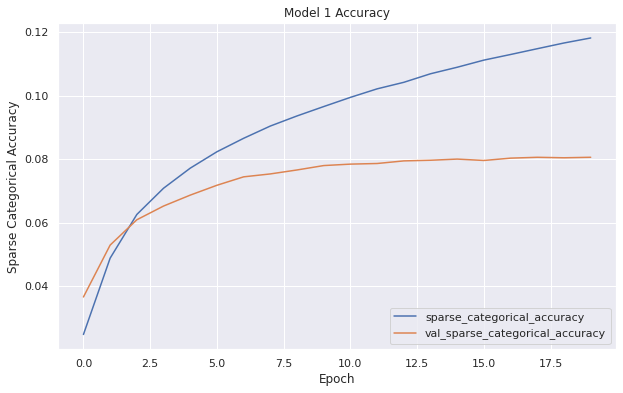

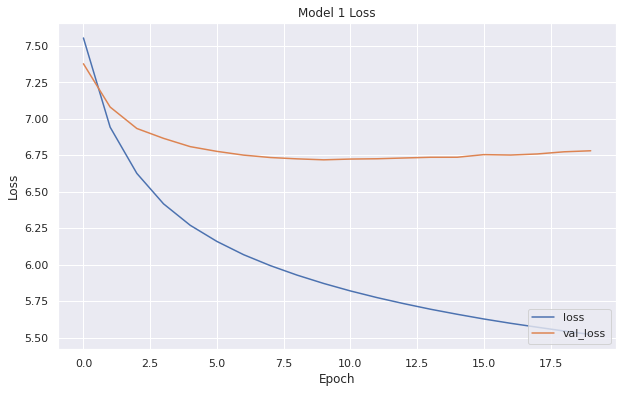

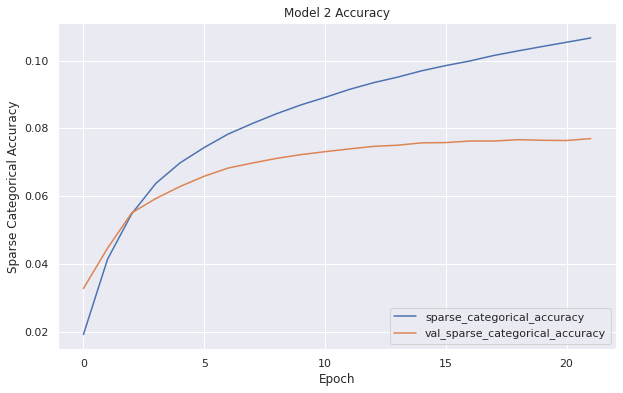

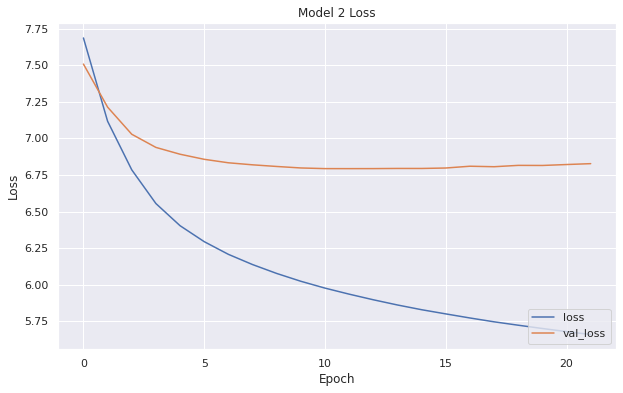

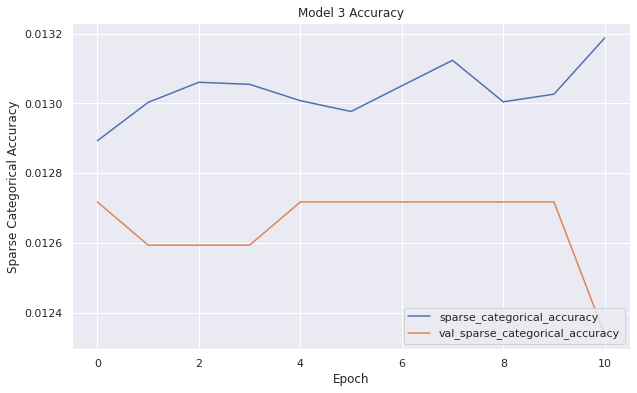

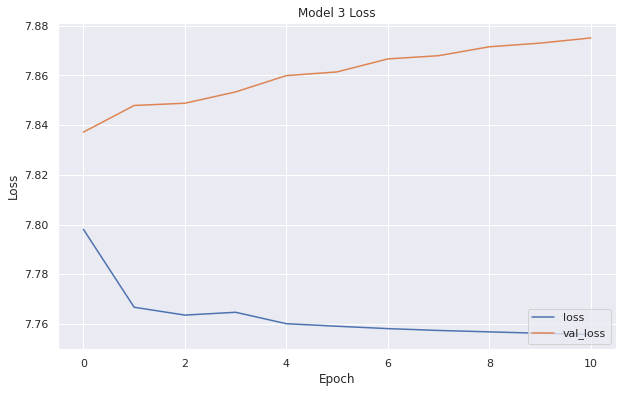

In [42]:
plot_history(history1, 'Model 1')
plot_history(history2, 'Model 2')
plot_history(history3, 'Model 3')

## Testing the model with actual data

`predict_next_words` function takes model, tokenizer and text as function argument and returns top 5 next words predicted by the model

In [43]:
def predict_next_words(model, tokenizer, text):
    # tokenize the text
    tokenized_sequence = tokenizer.texts_to_sequences([text])
    # pre-pad with 0's to make it of size MAX_SEQUENCE_LENGTH - 1
    input_sequences = tf.keras.preprocessing.sequence.pad_sequences(tokenized_sequence,
                                                                maxlen=MAX_SEQUENCE_LENGTH - 1,
                                                                padding='pre')
    # predict using model
    predictions = model.predict(input_sequences)
    ids = np.argsort(predictions, axis=1)[:,-5:] # indices of the top 5 predictions
    # print next word with score
    for id in ids[0]:
        print(tokenizer.index_word[id], "->", predictions[:, id].squeeze())

Load `model` and `tokenizer` from files

In [44]:
model = tf.keras.models.load_model(str(model_saved_dir))
with open(str(history_and_tokenizer_dir / f'tokenizer_{MAX_WORDS}_words.pickle'), 'rb') as f:
    tokenizer = pickle.load(f)

Test for custom texts by calling the function

In [45]:
text = input("Enter text: ")
predict_next_words(model, tokenizer, text)

Enter text: কে
ছিল -> 0.020689212
আর -> 0.022229258
এক -> 0.026407849
ভূমিকা -> 0.038361836
– -> 0.06996624


## Converting model to tensorflow lite format

Set converter parameters to convert the model with FP16 quantization

In [46]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
converter.target_spec.supported_types = [tf.float16]
converter.optimizations = [tf.lite.Optimize.DEFAULT]

Now convert the model and save as `.tflite` file

In [47]:
tflite_model = converter.convert()
# Save the model.
with open(model_saved_dir / 'bn_lstm_model.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmp0q8qguly/assets


INFO:tensorflow:Assets written to: /tmp/tmp0q8qguly/assets
2022-04-09 08:46:13.216885: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-04-09 08:46:13.216908: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-04-09 08:46:13.227419: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmp0q8qguly
2022-04-09 08:46:13.247911: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-04-09 08:46:13.248313: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmp0q8qguly
2022-04-09 08:46:13.319411: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-04-09 08:46:13.453699: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmp0q8qguly
2022-04-09 08:46:13.559680: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

This model can be used with android applications